In [36]:
import sys

sys.path.append("..")

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, m_e, eV, epsilon_0, e, physical_constants
from scipy.sparse.linalg import eigsh, cg
from scipy.linalg import eigh, eig
from scipy.sparse import csr_matrix
from scipy.integrate import simpson
import src.matrix_element_1d_sparse
import importlib
from src.matrix_element_1d_sparse import *

importlib.reload(src.matrix_element_1d_sparse)

<module 'src.matrix_element_1d_sparse' from '/home/yamamoto/physics/fem/fem_schrodinger/examples/../src/matrix_element_1d_sparse.py'>

In [38]:
xs = np.linspace(1e-20, 1e-9-, 1000)

x_centers = (xs[1:] + xs[:-1]) / 2

C1 = e**2 / (4 * np.pi * epsilon_0)
v = -C1 / x_centers


def solve_schrodinger(xs, v):
    femeig = Mel1dSparse(xs)
    K0 = femeig.get_K()
    M = femeig.get_M()
    K1 = femeig.get_M(v)

    # まずcoo_matrixからcsr_matrixへ変換
    K0_csr = csr_matrix(K0)
    M_csr = csr_matrix(M)
    K1_csr = csr_matrix(K1)

    # csr_matrixを使用してスライスする
    K0_dirichlet = K0_csr[1:-1, 1:-1]
    M_dirichlet = M_csr[1:-1, 1:-1]
    K1_dirichlet = K1_csr[1:-1, 1:-1]
    k = 3
    C0 = hbar**2 / (m_e)
    val, vec = eigsh(
        -1 / 2 * C0 * K0_dirichlet + K1_dirichlet,
        k=k,
        M=M_dirichlet,
        which="LA",
        sigma=-100 * eV,
    )
    return val, vec

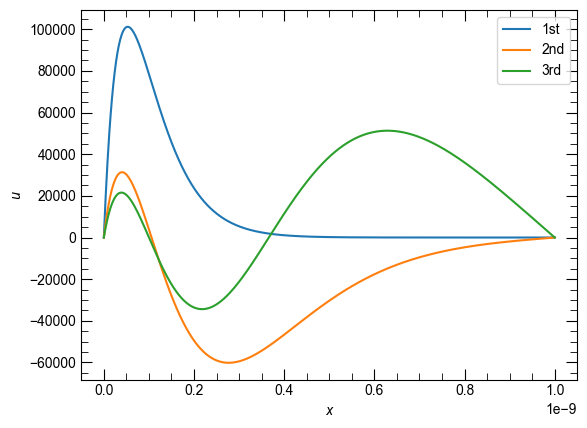

In [39]:
val, vec = solve_schrodinger(xs, v)
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [40]:
def solve_poisson(xs, vec_0):
    femeig = Mel1dSparse(xs)
    F = femeig.get_F(e * vec_0[:, 0] ** 2 / (4 * np.pi * x_centers**2) / epsilon_0)
    F = x_centers**2 * F[:-1]
    K_poisson = femeig.get_K(x_centers**2)
    K_poisson_csr = csr_matrix(K_poisson)
    K_poisson_dirichlet = K_poisson_csr[:-1, :-1]
    F[-1] -= K_poisson_csr[-2, -1] * (-e / (4 * np.pi * epsilon_0 * x_centers[-1]))
    x, info = cg(K_poisson_dirichlet, F)
    return x

(-10.0, 0.0)

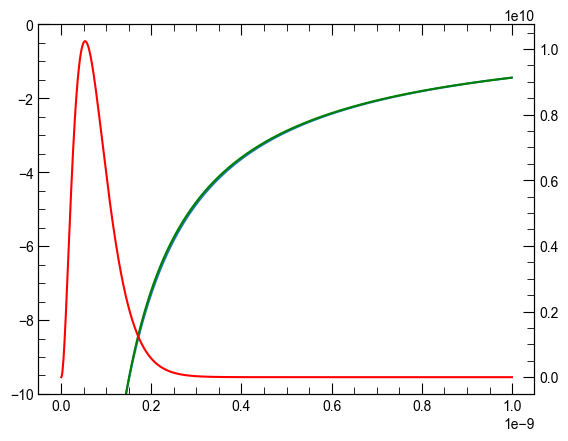

In [41]:
x = solve_poisson(xs, vec_0)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(xs[:-1], x)
ax2.plot(x_centers, vec_0[:, 0] ** 2, color="red")
ax.plot(xs[:-1], -e / (4 * np.pi * epsilon_0 * xs[:-1]), color="green")
ax.set_ylim(-1e1, 0)

In [42]:
v = -2 * C1 / x_centers - e * x
val, vec = solve_schrodinger(xs, v)
print(val / eV)
vec_0 = np.insert(vec, 0, 0, axis=0)

[-32.13835703  -4.55816776  -1.7281056 ]


(-1e-17, 1e-17)

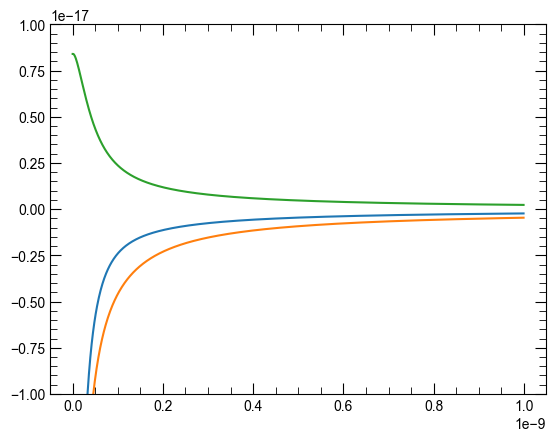

In [43]:
x = solve_poisson(xs, vec_0)
fig, ax = plt.subplots()
ax.plot(xs[:-1], v)
ax.plot(xs[:-1], -2 * C1 / x_centers)
ax.plot(xs[:-1], -e * x)
ax.set_ylim(-1e-17, 1e-17)

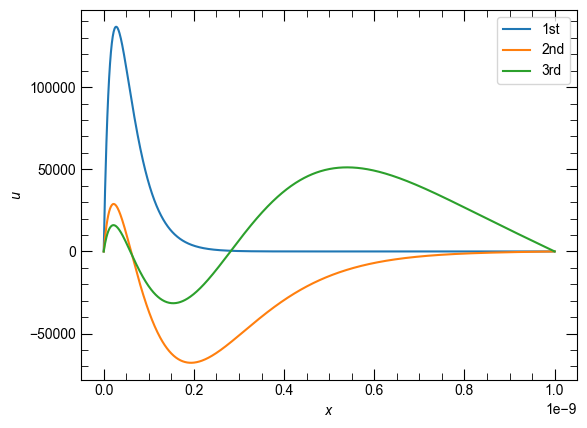

In [44]:
val, vec = solve_schrodinger(xs, v)
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [45]:
vec_a = vec_0
vec_b = vec_0
x_a = x
x_b = x
for i in range(10):
    v_a = -2 * C1 / x_centers - e * x_b
    val_a, vec_a = solve_schrodinger(xs, v_a)
    vec_0_a = np.insert(vec_a, 0, 0, axis=0)
    x_a = solve_poisson(xs, vec_0_a)
    v_b = -2 * C1 / x_centers - e * x_a
    val_b, vec_b = solve_schrodinger(xs, v_b)
    vec_0_b = np.insert(vec_b, 0, 0, axis=0)
    x_b = solve_poisson(xs, vec_0_b)
    print(val_a / eV)
    print(val_b / eV)

[-22.25874614  -4.000797    -1.54001485]
[-24.78887661  -4.14984725  -1.5932611 ]
[-23.92436398  -4.10047606  -1.57586427]
[-24.19493685  -4.11605942  -1.58138038]
[-24.10780069  -4.1110579   -1.5796127 ]
[-24.13561003  -4.11265788  -1.58017846]
[-24.12671035  -4.1121436   -1.5799965 ]
[-24.12955404  -4.11230927  -1.58005528]
[-24.12864579  -4.11225284  -1.58003512]
[-24.12893351  -4.11227475  -1.58004304]
[-24.12884541  -4.11226626  -1.58003988]
[-24.12887073  -4.11226712  -1.58004019]
[-24.12886272  -4.11227108  -1.58004178]
[-24.12886875  -4.11227088  -1.58004164]
[-24.12886601  -4.1122679   -1.58004046]
[-24.12886476  -4.11226883  -1.58004077]
[-24.12886617  -4.11227046  -1.58004145]
[-24.12886725  -4.11227303  -1.58004256]
[-24.12886844  -4.11226932  -1.58004118]
[-24.12886474  -4.11226675  -1.5800401 ]


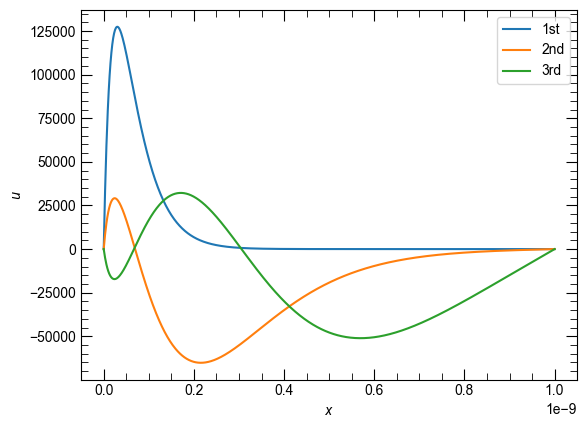

In [46]:
vec = vec_a
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")